In [ ]:
# variable for whether running on colab or not
running_on_colab = False

In [ ]:
# Import drive and connect
if running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    
#     import subprocess
#     subprocess.run("pip install pyrsgis", shell=True)
#     subprocess.run("pip install matplotlib_scalebar", shell=True)

    # Check GPU
    subprocess.run("nvidia-smi", shell=True)

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.model_selection import train_test_split

import dataImageUtils as diu
import plotEvalUtils as peu

import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  0
[]


In [4]:
# constants for program

input_bands = [i+1 for i in range(0,7)]
nBands = len(input_bands)
ndvi_band = 9
labels_band = 8

print('Analyzing bands: ', input_bands)
print('nBands: ', nBands)

downsampleMajority = False

diu.setGlobalVariables(input_bands, nBands, downsampleMajority)

if running_on_colab: image_base_path = "/content/drive/MyDrive/MangroveClassification/Images/"
else: image_base_path = "../SatelliteImages/"

Analyzing bands:  [1, 2, 3, 4, 5, 6, 7]
nBands:  7



First training image NDVI band:


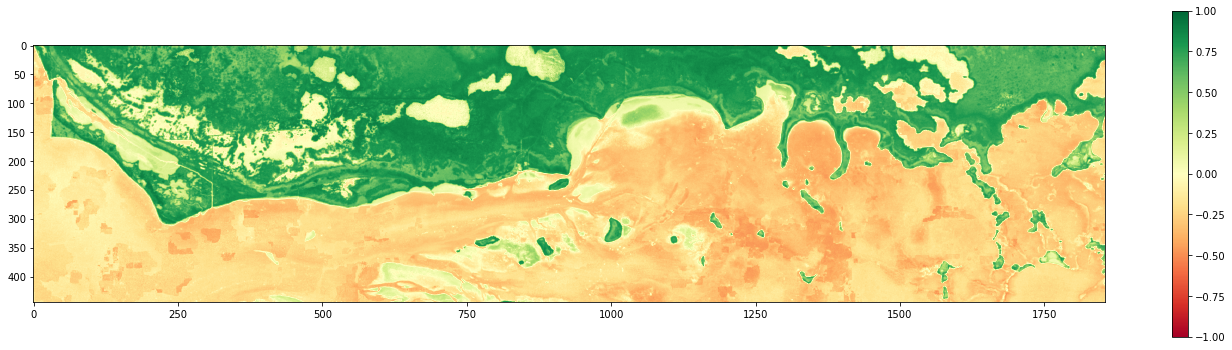


First training image mangroves from labels: 


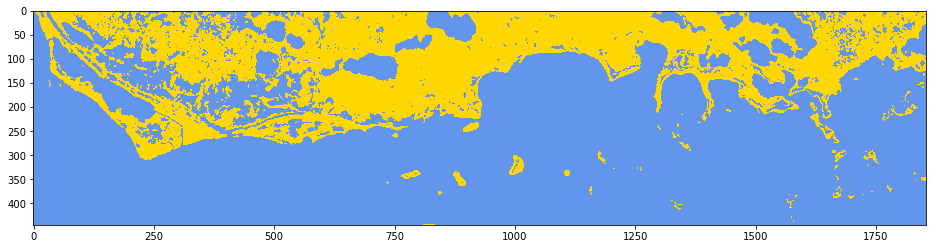

Using training data of length:  2473681
Class 0: 1795361 Class 1: 678320
Class 0:  72.6% Class 1:  27.4%


In [5]:
# generate training data from chosen images
training_images = []

training_images.append(image_base_path + "Florida_1_2000.tif")
training_images.append(image_base_path + "Florida_3_2000.tif")
training_images.append(image_base_path + "Brazil_2_2000.tif")

model_input_data, model_input_labels = diu.loadTrainingImages(training_images)

In [6]:
# split the data
xTrain, xTest, yTrain, yTest = train_test_split(model_input_data, model_input_labels, test_size=0.4, random_state=42, stratify=model_input_labels, shuffle=True)

# reshape it as an additional step for input into the NN
xTrain = xTrain.reshape((xTrain.shape[0], 1, nBands))
xTest = xTest.reshape((xTest.shape[0], 1, nBands))

print(xTrain.shape)
print(xTest.shape)


(1484208, 1, 7)
(989473, 1, 7)


In [7]:
# normalize bands
xTrain = diu.normalizeUInt16Band(xTrain)
xTest = diu.normalizeUInt16Band(xTest)

In [8]:
# Define the parameters of the model
model = keras.Sequential([
  keras.layers.Flatten(input_shape=(1, nBands)),
  keras.layers.Dense(14, activation='relu'),
  keras.layers.Dense(14, activation='relu'),
  keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print(model.summary)

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f9446962370>>


In [9]:
# fit the model
history = model.fit(xTrain, yTrain, validation_split=0.3, epochs=3)

Epoch 1/3
32468/32468 [==============================] - 166s 5ms/step - loss: 5047078024.6805 - accuracy: 0.8770 - val_loss: 0.1963 - val_accuracy: 0.9212
Epoch 2/3
32468/32468 [==============================] - 101s 3ms/step - loss: 121337157.2297 - accuracy: 0.9218 - val_loss: 0.1881 - val_accuracy: 0.9257
Epoch 3/3
32468/32468 [==============================] - 100s 3ms/step - loss: 441745619.1581 - accuracy: 0.9249 - val_loss: 0.1864 - val_accuracy: 0.9267


In [10]:
print(history.history)

# could make some plots of the metrics/convergance - would want to plot the f1 score though instead of accuracy
# fig, ax = plt.subplots()

# mae = history.history['mae']
# val_mae = history.history['val_mae']

# epochs = range(len(mae))

# ax.plot(epochs, mae, label='Train MAE')
# ax.plot(epochs, val_mae, label='Val MAE')

# ax.legend();

{'loss': [2026752256.0, 416051008.0, 235656224.0], 'accuracy': [0.9034193158149719, 0.9232904314994812, 0.9249324798583984], 'val_loss': [0.19629520177841187, 0.18808524310588837, 0.18643617630004883], 'val_accuracy': [0.9211679100990295, 0.9257427453994751, 0.9266882538795471]}


Confusion matrix:
 [[671089  47056]
 [ 24952 246376]]

P-Score: 0.840, R-Score: 0.908
Accuracy: 0.927
f1: 0.872
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95    718145
         1.0       0.84      0.91      0.87    271328

    accuracy                           0.93    989473
   macro avg       0.90      0.92      0.91    989473
weighted avg       0.93      0.93      0.93    989473



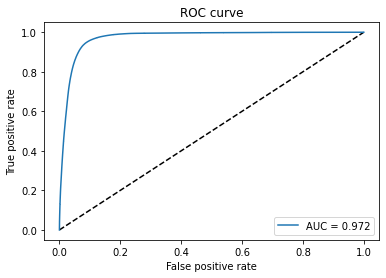

In [11]:
# Predict for test data 
yTest_pred_prob = model.predict(xTest)
yTest_pred_prob = yTest_pred_prob[:,1] # grab probablities for class label 1

peu.printClassificationMetrics(yTest, yTest_pred_prob)
peu.makeROCPlot(yTest, yTest_pred_prob)

Predicting for image: ../SatelliteImages/Florida_1_2020.tif

Image NDVI band:


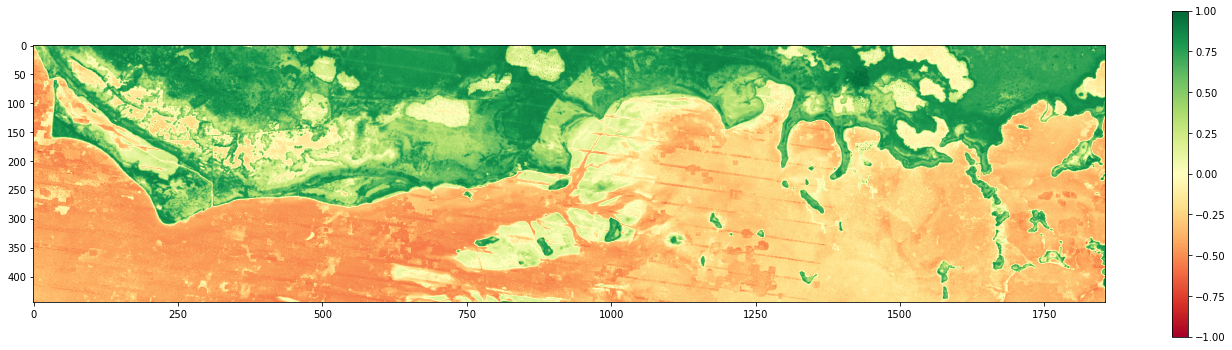


Label mangroves from 2000 data:


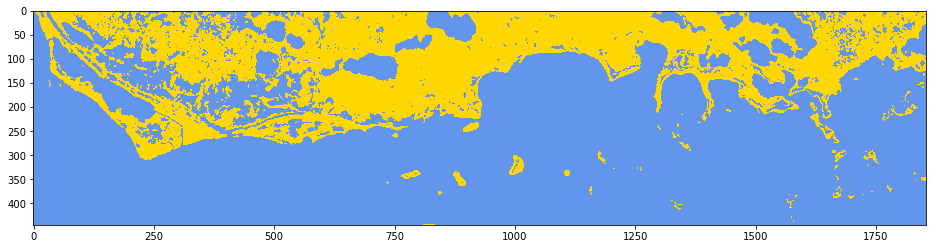

Confusion matrix:
 [[558772  21114]
 [ 73947 171642]]

P-Score: 0.890, R-Score: 0.699
Accuracy: 0.885
f1: 0.783
              precision    recall  f1-score   support

           0       0.88      0.96      0.92    579886
           1       0.89      0.70      0.78    245589

    accuracy                           0.88    825475
   macro avg       0.89      0.83      0.85    825475
weighted avg       0.89      0.88      0.88    825475



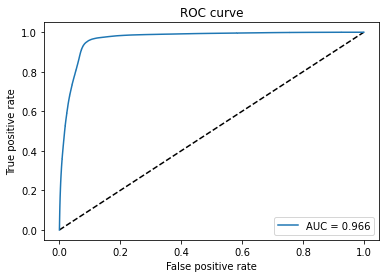


Predicted mangroves:


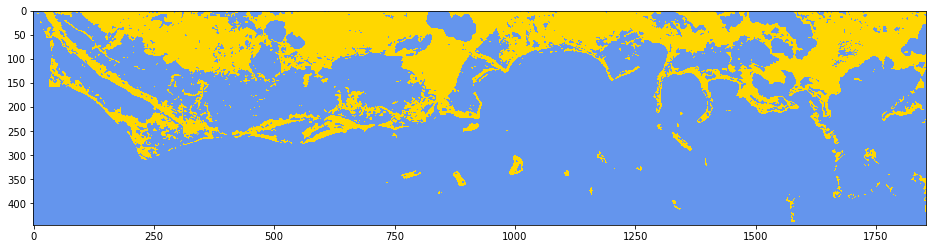


Difference between predicted and labeled mangroves:


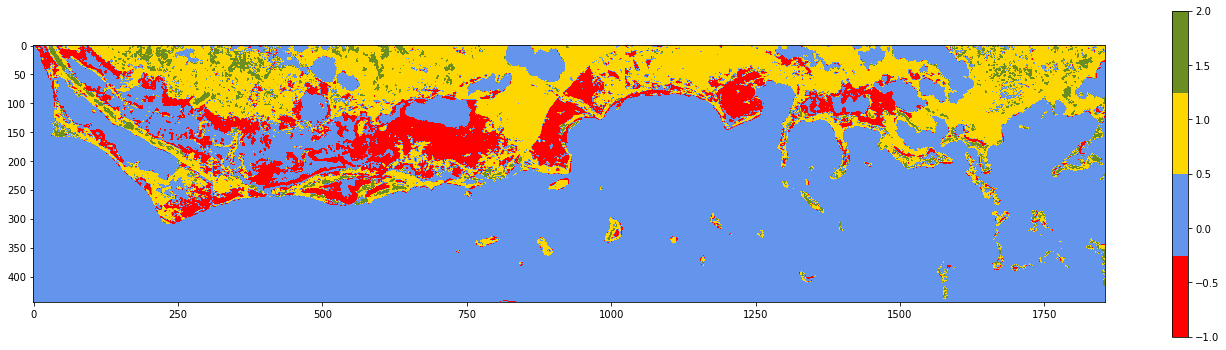

Predicting for image: ../SatelliteImages/Brazil_1_2000.tif

Image NDVI band:


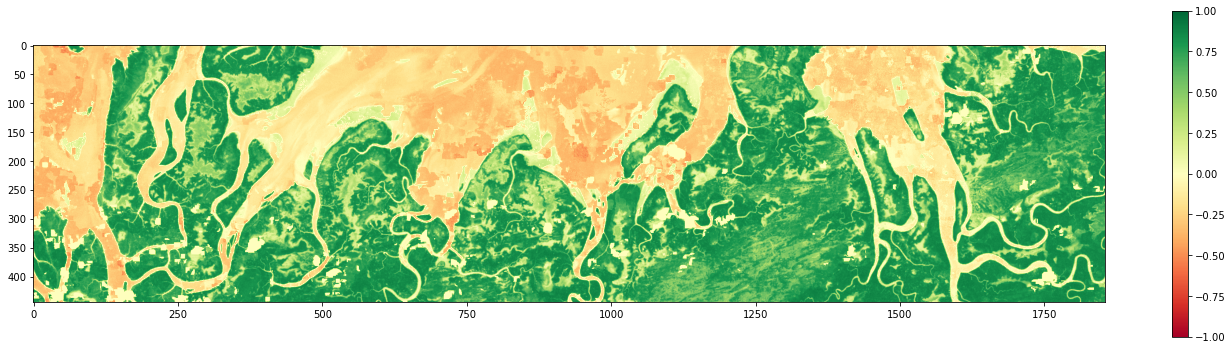


Label mangroves from 2000 data:


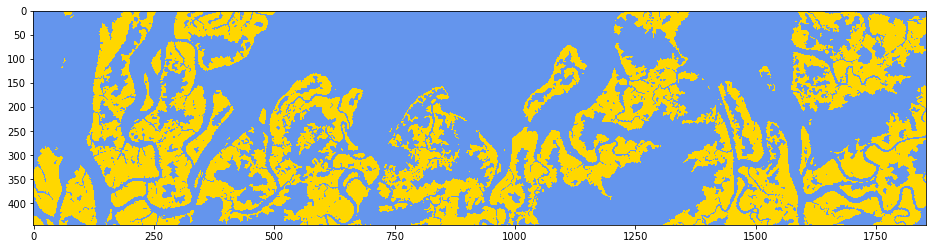

Confusion matrix:
 [[484942  51381]
 [ 45474 243678]]

P-Score: 0.826, R-Score: 0.843
Accuracy: 0.883
f1: 0.834
              precision    recall  f1-score   support

           0       0.91      0.90      0.91    536323
           1       0.83      0.84      0.83    289152

    accuracy                           0.88    825475
   macro avg       0.87      0.87      0.87    825475
weighted avg       0.88      0.88      0.88    825475



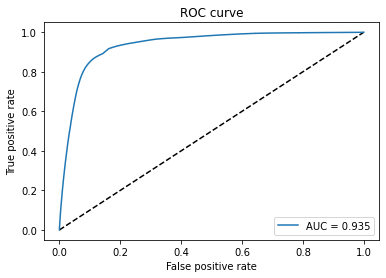


Predicted mangroves:


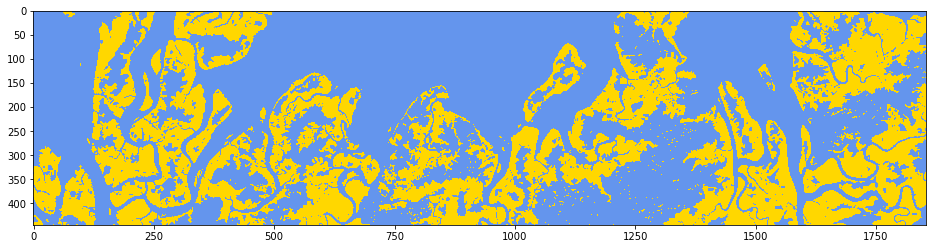


Difference between predicted and labeled mangroves:


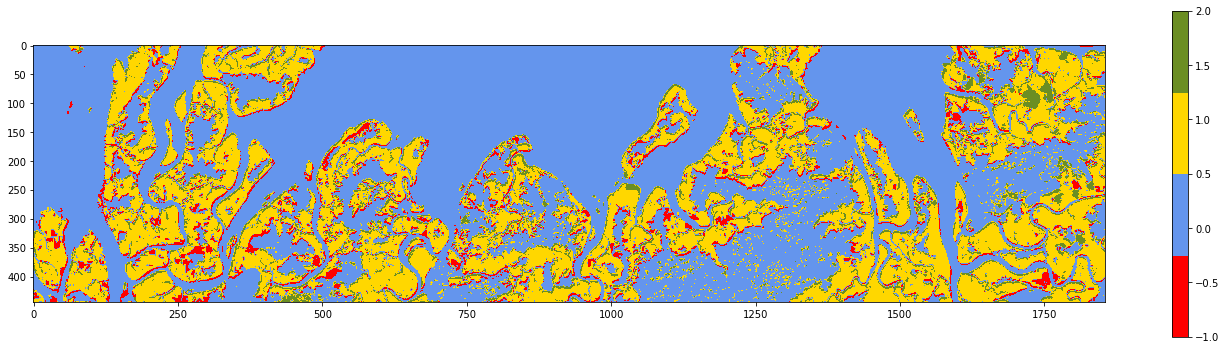

In [12]:
# apply model to new images
diu.predictOnImage(model, image_base_path + "Florida_1_2020.tif")
# diu.predictOnImage(model, image_base_path + "Florida_3_2020.tif")
diu.predictOnImage(model, image_base_path + "Brazil_1_2000.tif")


In [13]:
print('not now timeout!')

not now timeout!
